# Mask-Detection using Transfer Learning

Own-model training for Mask and without Maks detector.

Load the necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import cv2 as cv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Build the dataset

### Download the dataset
You will use a dataset containing several hundreds images of person with and without mask. 

Download and extract a zip file containing the images. Then  create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility.

[Tutorial for loading images](https://www.tensorflow.org/tutorials/load_data/images).

Install gdwon to be able to load from Google

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1lYOgCLLJU8TCIeTxJHkjsxBq_GPzQYb9

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lYOgCLLJU8TCIeTxJHkjsxBq_GPzQYb9
From (redirected): https://drive.google.com/uc?id=1lYOgCLLJU8TCIeTxJHkjsxBq_GPzQYb9&confirm=t&uuid=f64d62d1-dfd1-4b22-85a9-85a2896c8fea
To: /content/edx_transfer_learningv3.zip
100% 2.01G/2.01G [00:33<00:00, 60.0MB/s]


In [ ]:
!unzip edx_transfer_learningv3.zip

Archive:  edx_transfer_learningv3.zip
   creating: edx_transfer_learningv3/
   creating: edx_transfer_learningv3/edx_transfer_learning/
   creating: edx_transfer_learningv3/edx_transfer_learning/train/
   creating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0000.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0001.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0002.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0003.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0004.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0005.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/without_mask/seed0006.png  
  inflating: edx_transfer_learningv3/edx_transfer_learning/train/wit

Indicate the path of the training images

In [ ]:
import os
os.chdir("/content/edx_transfer_learningv3/edx_transfer_learning/train/without_mask")

Load the training dataset from a directory

In [ ]:
path_to_zip = "/content/"
PATH = os.path.join(os.path.dirname(path_to_zip), 'edx_transfer_learningv3/edx_transfer_learning/')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 602 files belonging to 2 classes.


Load the validation set from a directory

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Display some sample images and their labels, using matplotlib.

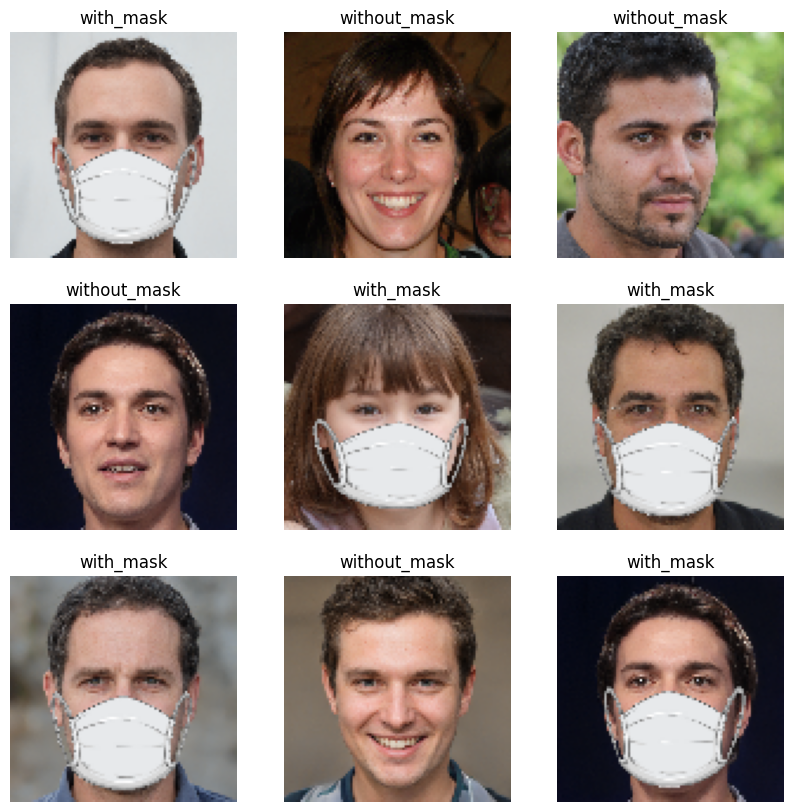

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split the dataset

Divide a subdataset from the validation dataset for final testing, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:

#for batch in train_dataset:
#    images, labels = batch
#    print("Images:", images.numpy())
#    print("Labels:", labels.numpy())


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. Dynamically adjusts the buffer used by TensorFlow for better memory management


To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Use data augmentation

Artificially introduce sample diversity by applying random, yet realistic, transformations to the training images to expand the dataset. 

Apply rotations and flip the data horizontally. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). 

You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
# Define your data augmentation function and preprocessing
def data_augmentation(image, labels):
    # Example augmentations
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2, seed=6)
    image /= 255.0

    ##Check for rotation options

    return image, labels

It displays some samples from the dataset in grayscale.

(32, 96, 96, 3)
tf.Tensor(
[[[ 63.833332  74.97222   40.666668]
  [ 66.333336  82.833336  48.916668]
  [ 74.13889   89.16667   51.86111 ]
  ...
  [ 50.833332  71.83329   37.861103]
  [ 52.333332  71.333336  39.5     ]
  [ 59.333355  75.11111   41.666645]]

 [[ 68.91667   85.91667   47.25    ]
  [ 76.5       93.25      52.25    ]
  [ 81.083336  96.583336  55.      ]
  ...
  [ 75.08331   94.58331   51.333374]
  [ 69.75      91.5       46.5     ]
  [ 81.833374  98.66669   55.583344]]

 [[ 77.13889   95.13889   55.305557]
  [ 79.416664  96.416664  55.5     ]
  [ 88.361115 105.361115  60.500004]
  ...
  [100.83333  117.6667    61.694435]
  [ 99.83333  115.5       60.583336]
  [ 98.194466 117.16667   62.333355]]

 ...

 [[ 85.666954  59.000202  45.305725]
  [102.833374  70.91669   56.333374]
  [ 83.444496  59.611164  46.75006 ]
  ...
  [117.63874  132.33325   67.49988 ]
  [112.24994  128.24994   64.24994 ]
  [119.05549  134.36102   65.49994 ]]

 [[ 93.08333   64.75      51.666664]
  [ 72.75 

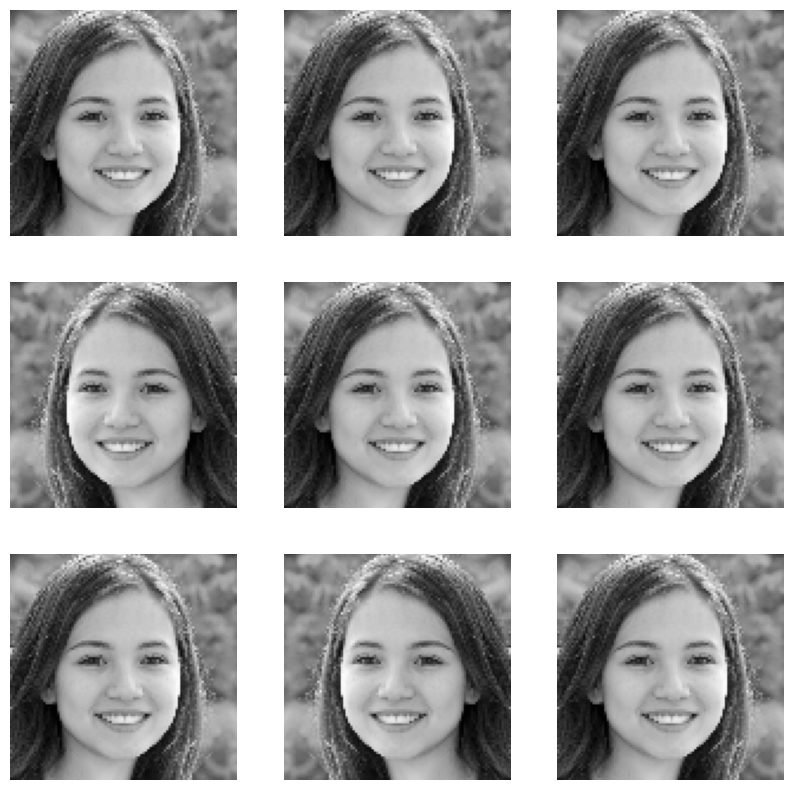

In [ ]:
#for image, _ in train_dataset.take(1):
image, label = next(iter(train_dataset.take(1)))
plt.figure(figsize=(10, 10))
print(image.shape)
print(image[0])
print(label.shape)
print(label)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(image[0], label[0])
  plt.imshow(augmented_image[0], cmap='gray')
  plt.axis('off')

In [ ]:
# Apply the augmentations
aug_train_ds = train_dataset.map(data_augmentation, num_parallel_calls=AUTOTUNE)
aug_val_ds = validation_dataset.map(data_augmentation, num_parallel_calls=AUTOTUNE)
aug_test_ds = test_dataset.map(data_augmentation, num_parallel_calls=AUTOTUNE)

In [ ]:

print(aug_train_ds.element_spec)
num_elements = tf.data.experimental.cardinality(aug_train_ds).numpy()
print(f'Total number of batches in the dataset: {num_elements}')
# If the last batch is not full, you need to handle that
total_elements = 0

# Calculate the total elements by iterating through the dataset
for images, labels in aug_train_ds:
    total_elements += images.shape[0]

print(f'Total number of elements in the dataset: {total_elements}')


(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Total number of batches in the dataset: 19
Total number of elements in the dataset: 602


## Build the Model

### Create the model
Create and compile a custom, simple and straightforward model using keras

In [ ]:
tf.keras.backend.clear_session()

Define the architecture of the neural network

In [ ]:
#Using Keras API for model architecture
#Delete some conv and max pool networks
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(96, 96,1)),
  keras.layers.Conv2D(filters=6, kernel_size=(3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=24, kernel_size=(3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu'),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(1)
])

learning_rate = 0.001
#model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 96, 96, 6)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 48, 48, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 48, 48, 12)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 24, 24, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 24)     │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 6, 6, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 3, 3, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 192)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,265 (977.60 KB)

 Trainable params: 250,265 (977.60 KB)

 Non-trainable params: 0 (0.00 B)

## Train and Evaluate the model

### Train the model


Train the model for 5 periods

In [ ]:
epochs = 5 # YOUR CODE HERE #

history = model.fit(aug_train_ds, epochs= epochs , verbose=1, validation_data = aug_val_ds)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5154 - loss: 0.6912 - val_accuracy: 0.5000 - val_loss: 0.6815
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.5400 - loss: 0.6399 - val_accuracy: 0.9047 - val_loss: 0.3989
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8791 - loss: 0.2665 - val_accuracy: 0.9913 - val_loss: 0.0482
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9627 - loss: 0.0899 - val_accuracy: 0.9975 - val_loss: 0.0318
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9927 - loss: 0.0235 - val_accuracy: 0.9988 - val_loss: 0.0148


In [ ]:
#from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')
#model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint])

Show the learning curves of the training and validation accuracy/loss to analyze the results.

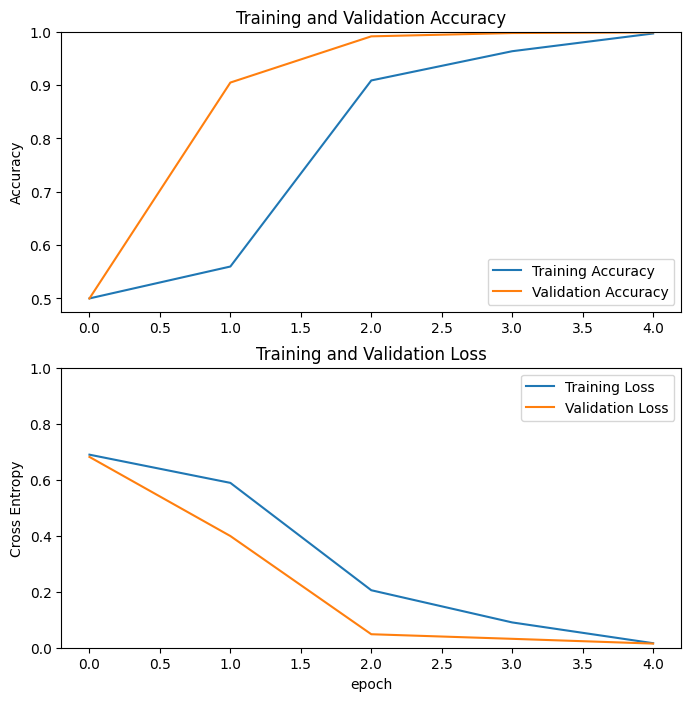

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Guarda el modelo en formato SavedModel
model.save('/content/drive/MyDrive/modeloY.h5')


### Evaluate your model

Show the accuracy of the model

In [ ]:
loss, accuracy = model.evaluate(aug_test_ds)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - accuracy: 1.0000 - loss: 0.0040
Test accuracy : 1.0


Print the results from a bunch of the images in the test dataset


Predictions:
 [1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1]
Labels:
 [1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1]


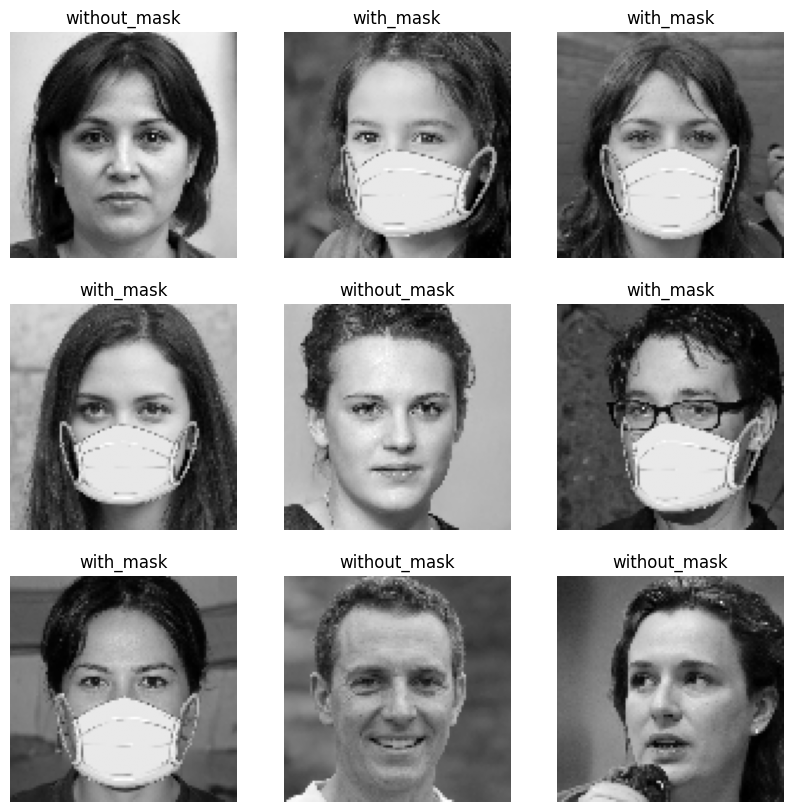

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = aug_test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.where(predictions < 0, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i], cmap='gray')
  plt.title(class_names[predictions[i]])
  plt.axis("off")


# Saving the model

In [ ]:
#os.chdir("/content/")
#export_dir = '/content/saved_model/1'
#tf.saved_model.save(model, export_dir)


In [ ]:
os.chdir("/content/")
model.save('mask.h5')

In [ ]:
#For ziping and further downloading
!zip -r saved_model.zip '/content/saved_model'

# Loading and converting to TFlite

In [ ]:
#os.chdir("/content/")
#!unzip mask_small_model.zip
#model = keras.models.load_model('mask.h5')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 96, 96, 6)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 48, 48, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 48, 48, 12)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 24, 24, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 24)     │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 6, 6, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 3, 3, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 192)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 750,797 (2.86 MB)

 Trainable params: 250,265 (977.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 500,532 (1.91 MB)

In [ ]:
# Convert the model without optimization
#import_dir = 'saved_model/1'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
#converter = tf.lite.TFLiteConverter.from_saved_model(import_dir)
#tflite_model = converter.convert()
tflite_model_size = len(tflite_model) / 1024
print('Original model size = %dKBs.' % tflite_model_size)

Saved artifact at '/tmp/tmp2q5n67vt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_59')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139500332334736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744349840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744351376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744348112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744347728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744347152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1394997443469

In [ ]:
def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
    for input_value, _ in aug_test_ds.take(100):
        yield [input_value]

Quantize the model from float 32 to int 8, reducing the model to a quarter of its size

In [ ]:
# Convert the model WITH optimization (Quiantization)
opt_converter = tf.lite.TFLiteConverter.from_keras_model(model)
opt_converter.optimizations = [tf.lite.Optimize.DEFAULT]
opt_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
opt_converter.inference_input_type = tf.int8
opt_converter.inference_output_type = tf.int8
opt_converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
opt_converter._experimental_disable_per_channel_quantization_for_dense_layers = True
opt_tflite_model = opt_converter.convert()
opt_tflite_model_size = len(opt_tflite_model) / 1024
print('Quantized model size = %dKBs.' % opt_tflite_model_size)

Saved artifact at '/tmp/tmptrfoqt12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_59')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139500332334736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744349840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744351376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744348112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744347728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744347152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139499744350800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1394997443469

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model size = 261KBs.



Export both quantized and non-quantized models

In [ ]:
#Save model
os.chdir('/content/drive/MyDrive')
#drive.mount('/content/drive')
open('Qmodel.tflite', "wb").write(opt_tflite_model)
open('wQmodel.tflite', "wb").write(tflite_model)

1007044

In [ ]:
#@title Run this cell each time to test your model's accuracy (make sure to change the filename)
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = 'Qmodel.tflite'                 # Change the filename here for with and without quantization
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(aug_test_ds.take(100)): # Changed to take 100 to get 100 predictions
  for i in range(img.shape[0]): # loop through each image in the batch
    input_scale, input_zero_point = interpreter.get_input_details()[0]["quantization"]
    # Convert the image to INT8
    int8_img = np.clip(img[i:i+1] / input_scale + input_zero_point, -128, 127).astype(np.int8)
    interpreter.set_tensor(input_index, int8_img) # set tensor with single image
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[i]) # append the label for the current image
    test_imgs.append(img[i:i+1]) # append the current image

score = 0
for item in range(0,100):
  prediction=np.where(predictions[item] < 0.5, 0, 1)
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

# Model quantized - Ex. 99 Correct
# Model without quantization - Ex. 100 Correct

# Note: since training starts from a random intialization it would not be
#       surprising if your result is off by 1 or 2 correct.

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

Out of 100 predictions I got 99 correct


In [ ]:
#@title Define utility functions once for plotting
# Utilities for plotting

class_names = ['Mask', 'No Mask']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap='gray')

    #print(predictions_array)
    predicted_label = np.where(predictions_array[0][0] < 0, 0, 1)
    #print(predicted_label)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.1f} (int8) ({})".format(class_names[predicted_label],
                                         predictions_array[0][0],
                                         class_names[true_label]), color=color)

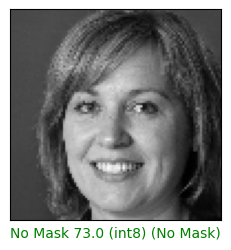

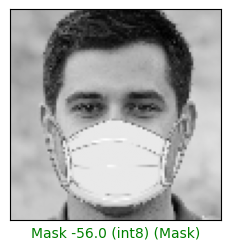

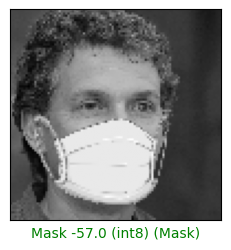

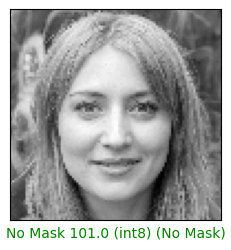

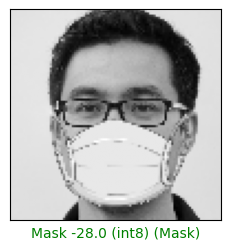

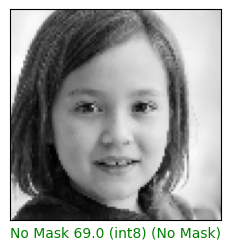

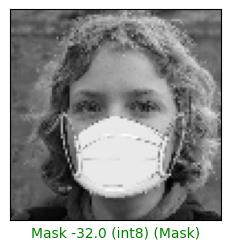

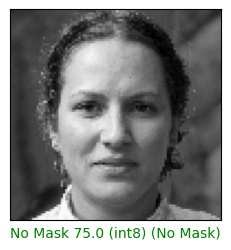

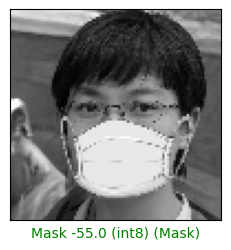

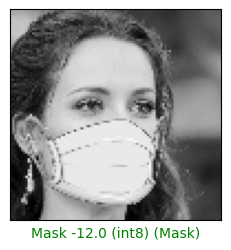

In [ ]:
max_index = 7 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

## Exporting the model for microcontroller
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on an Embedded Platform we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [ ]:
MODEL_TFLITE = 'Qmodel.tflite'
MODEL_TFLITE_MICRO = 'Qmodel.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Print out the model contents, these values can be pasted in a .h file to avoid SPIFFS 

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
!cat {MODEL_TFLITE_MICRO}

Streaming output truncated to the last 5000 lines.
  0x4a, 0x2f, 0x20, 0xef, 0xca, 0x5d, 0x0f, 0x4e, 0x07, 0x03, 0x8a, 0xb1,
  0x24, 0x1d, 0xbd, 0x4c, 0x2d, 0xb5, 0x42, 0x22, 0x31, 0x8e, 0xbb, 0x0b,
  0xbe, 0x14, 0x65, 0xb1, 0xab, 0x07, 0xcc, 0xa8, 0xa3, 0xe6, 0x13, 0x4f,
  0xf6, 0x14, 0x58, 0xef, 0xf9, 0x28, 0x5d, 0x3e, 0xac, 0x22, 0xdd, 0x5b,
  0x03, 0xd6, 0xc8, 0x29, 0x9d, 0xda, 0xf9, 0x88, 0x87, 0x43, 0x39, 0x13,
  0x17, 0xf5, 0xa2, 0x94, 0x43, 0x0d, 0xf5, 0x41, 0x52, 0x12, 0xbf, 0x59,
  0xca, 0x30, 0xaa, 0x1f, 0xdc, 0xb6, 0x45, 0x01, 0x95, 0xf8, 0x39, 0xdd,
  0xbc, 0xb7, 0x1a, 0x3b, 0x26, 0x2d, 0x56, 0xc0, 0x00, 0x3b, 0x8a, 0xb9,
  0xaa, 0x3e, 0x61, 0xd7, 0x28, 0x27, 0xe7, 0xa6, 0x5e, 0x52, 0x07, 0x32,
  0x3d, 0xd7, 0x34, 0x0c, 0x45, 0x31, 0xbe, 0xf4, 0x46, 0xcb, 0xf7, 0xe0,
  0x4a, 0xd0, 0x03, 0x0f, 0xe0, 0x2b, 0x20, 0x1b, 0x3f, 0x19, 0xdb, 0xb8,
  0xbc, 0x9d, 0xdb, 0x8f, 0xe2, 0x30, 0x8a, 0xf4, 0xa4, 0x99, 0xad, 0xfb,
  0x51, 0xed, 0xf5, 0xc3, 0x93, 0xdf, 0xb2, 0xf1, 0x15, 0xe8,

### Performance Metrics

Inferences from the model deployed by the MCU

Accuracy:  0.9
Recall:  [0.8 1. ]
Precision:  [1.         0.83333333]
F1 Score:  [0.88888889 0.90909091]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



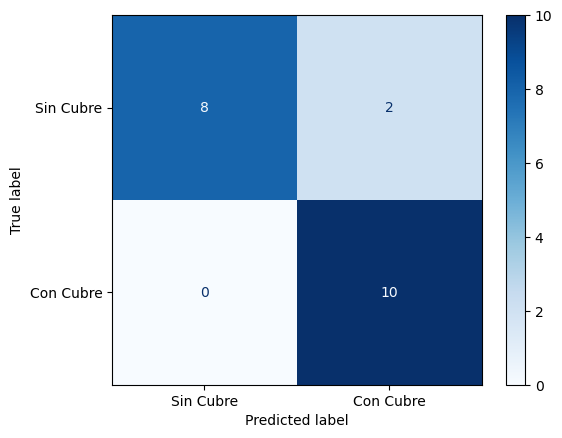

In [1]:
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score


# Predicción

y_pred_inf = [0,0,0,0,1,0,1,0,0,0,
              1,1,1,1,1,1,1,1,1,1]

y_inf = [0,0,0,0,0,0,0,0,0,0,
         1,1,1,1,1,1,1,1,1,1]

# Metricas
accuracy = accuracy_score(y_inf, y_pred_inf)
recall = recall_score(y_inf, y_pred_inf, average=None)
precision = precision_score(y_inf, y_pred_inf, average=None)
f1 = f1_score(y_inf, y_pred_inf, average=None)

print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 Score: ', f1)

# Reporte
print("Reporte de Clasificación:")
print(classification_report(y_inf, y_pred_inf))

# Matriz de confusión
cm = confusion_matrix(y_inf, y_pred_inf)

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sin Cubre", "Con Cubre"])
disp.plot(cmap="Blues", values_format='d')
